# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

## Portfolio Optimization

(**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.)

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

In order to create a stock portfolio, let us begin by scraping S&P 500 data off of wikipedia for the tickers.

In [21]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_df = pd.read_html(url, header=0)[0]

# Clean up DataFrame
sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
sp500_df.columns = ['Ticker', 'Company', 'Sector', 'Industry']


# Group by sector or industry
sector_groups = sp500_df.groupby('Sector')
industry_groups = sp500_df.groupby('Industry')

In [22]:
sp500_df['Sector'].value_counts()

Sector
Industrials               78
Financials                73
Information Technology    69
Health Care               60
Consumer Discretionary    51
Consumer Staples          38
Utilities                 31
Real Estate               31
Materials                 26
Communication Services    23
Energy                    23
Name: count, dtype: int64

I am trying to write a customizable portfolio optimizer. So here, we select 3 sectors at random and select a total of 20 stocks from the 4 sectors to work with.

In [23]:
chosen_sectors = np.random.choice(sp500_df['Sector'].unique(), size=4, replace=False)
print("Stocks will be chosen from: ", chosen_sectors)

Stocks will be chosen from:  ['Consumer Staples' 'Communication Services' 'Utilities' 'Industrials']


In [24]:
ticker_list = np.array(sp500_df[sp500_df['Sector'].isin(chosen_sectors)]['Ticker'])
stock_tickers = np.random.choice(ticker_list, size=20, replace=False)
print('Chosen Stocks to be optimized in portfolio: ', stock_tickers)

Chosen Stocks to be optimized in portfolio:  ['TT' 'EXPD' 'LW' 'META' 'PG' 'BR' 'PNW' 'TDG' 'TSN' 'BA' 'VRSK' 'DAL'
 'NSC' 'SWK' 'ROL' 'ADP' 'WEC' 'KVUE' 'WAB' 'NFLX']


In [25]:
stock_tickers = ['AMZN', 'MSFT', 'ANET', 'ICLN', 'FBCG', 'XLC', 'FBCV', 'JEPQ', 'SCHD', 'VGT', 'VTI', 'VPU', 'VIG', 'RIVN', 'LLY', 'GOOGL', 'MPWR', 'SOXL', 'SKYY', 'BOTZ', 'VOO', 'SPY']
# stock_tickers = ['BOTZ', 'MSFT', 'SPY', 'VPU']

I intend to include liquidity into consideration while optimizing the portfolio, hence I need to download both the stock price at closing and the volume traded.

In [26]:
data_download = yf.download(stock_tickers, start="2024-02-28", end="2025-06-28")
data_download.dropna(axis=1, inplace=True)  # Drop stocks with incomplete data

data = data_download['Close']
volume_data = data_download['Volume']

[*********************100%***********************]  22 of 22 completed


In [27]:
# Create the Ticker object

ticker = 'AAPL'
stock = yf.Ticker(ticker)

# Get key fundamentals
info = stock.info

# Display common fundamental metrics
fundamentals = {
    "Symbol": ticker,
    "Company Name": info.get("longName"),
    "Sector": info.get("sector"),
    "Market Cap": info.get("marketCap"),
    "P/E Ratio (TTM)": info.get("trailingPE"),
    "EPS (TTM)": info.get("trailingEps"),
    "Forward P/E": info.get("forwardPE"),
    "Dividend Yield": info.get("dividendYield"),
    "Beta": info.get("beta"),
    "52 Week High": info.get("fiftyTwoWeekHigh"),
    "52 Week Low": info.get("fiftyTwoWeekLow")
}
print(fundamentals)

{'Symbol': 'AAPL', 'Company Name': 'Apple Inc.', 'Sector': 'Technology', 'Market Cap': 3172961353728, 'P/E Ratio (TTM)': 33.090343, 'EPS (TTM)': 6.42, 'Forward P/E': 25.564379, 'Dividend Yield': 0.51, 'Beta': 1.211, '52 Week High': 260.1, '52 Week Low': 169.21}


In [9]:
avg_volume = volume_data.mean()
volume_vec = avg_volume.values
# Normalize volume_vec
volume_vec -= np.mean(volume_vec)
volume_vec /= np.linalg.norm(volume_vec)

Calculate daily returns and covariances

In [10]:
daily_returns = (data/data.shift(1)).dropna()  - 1
cov_matrix = daily_returns.cov()
mean_returns = daily_returns.mean()
annual_cov_matrix = cov_matrix * 252

/opt/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/miniconda3/lib/python3.13/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Visualize covariance matrix

/opt/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


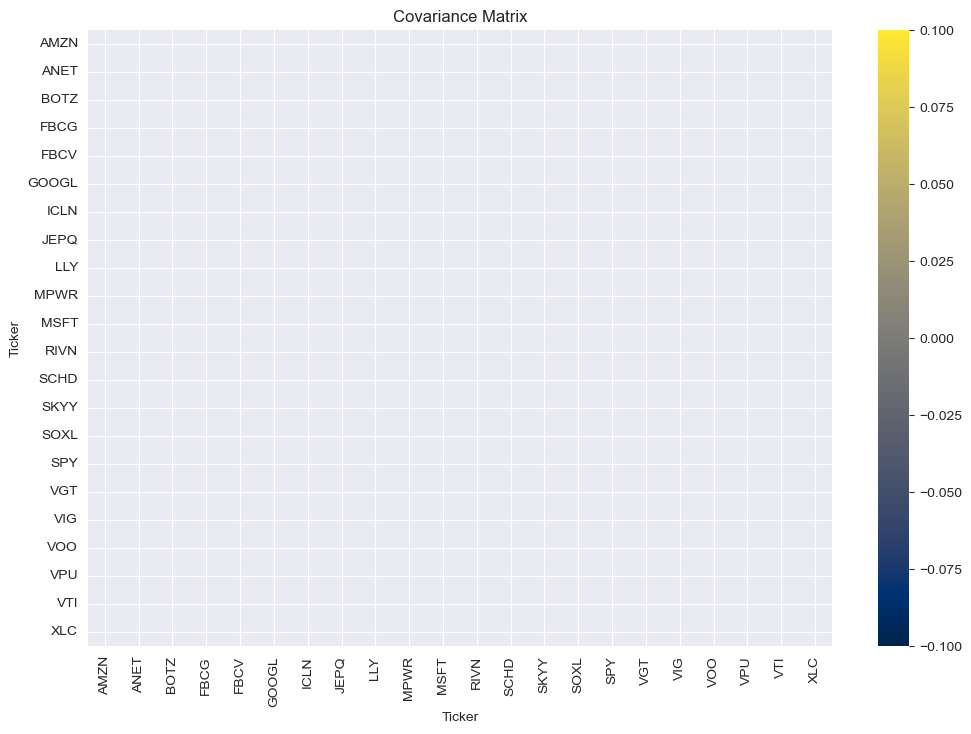

In [11]:
plt.figure(figsize = (12,8))
sns.heatmap(annual_cov_matrix, annot=True, cmap='cividis', fmt ='.2f')
plt.title('Covariance Matrix')
plt.show()

Consider a portfolio of stocks $\{S_1, S_2, ..., S_N\}$ with weights $\{w_1, w_2, ..., w_N\}$. The expected value of the portfolio is
$$
\mathbb{E}[P] = \sum_{i = 1}^N w_i\ \mathbb{E}[S_i]
$$

We can use the annualized average daily simple return for $\mathbb{E}[S_i]$. The variance of the portfolio is given by

$$
\sigma^2[P] = \sum_{i,j} w_i\text{Cov}(S_i, S_j) w_j = w^T\cdot \Sigma \cdot w
$$
where $\Sigma$ is the covariance matrix and $\cdot$ indicates matrix multiplication.

Finally, assume that the average traded volume of stock $S_i$ is $V_i$. Low $V_i$ implies low liquidity, which means that you cannot sell much stock without changing its price in the market. We want to punish low liquidity. 

Thus, we obtain the _liquidity aware objective function_ with a free parameter $\lambda$,
$$
    \mathcal{O}[w] = w^T\cdot\Sigma\cdot w + \lambda\left(\frac{w^T\cdot w}{V}\right)
$$

In what follows, we construct this objective function given a set of stocks and minimize it using scipy.optimize


In [12]:
n_assets = len(mean_returns)

def liquidity_aware_objective(weights, cov_matrix, volume_vector, lambd):
    portfolio_variance = weights.T @ cov_matrix @ weights
    liquidity_penalty = np.sum(weights**2 / volume_vector)
    return portfolio_variance + lambd * liquidity_penalty

def get_constraints(mu, target_return):
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Fully invested
        {'type': 'ineq', 'fun': lambda weights: weights @ mu - target_return}, # Return constraint
        )
    return constraints

Calculate efficient frontier:

Efficient Frontier is a set of portfolios that satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk).

In [13]:
mu = mean_returns
cov = annual_cov_matrix
volume_vector = volume_vec
n_points = 100
lambd = 0

target_returns = np.linspace(mu.min(), mu.max(), n_points)

risks = []
returns = []
weights_list = []

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)


for target in target_returns:
    constraints = get_constraints(mu, target)
    x0 = initial_weights  # Initial guess

    result = minimize(
        liquidity_aware_objective, x0,
        args=(cov, volume_vector, lambd),
        method='SLSQP',
        constraints=constraints,
        bounds = [(0.001, 1.0)] * n_assets
    )
    if result.success:
        optimal_weights = result.x
        portfolio_return = optimal_weights @ mu
        portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
        returns.append(portfolio_return)
        risks.append(portfolio_risk)
        weights_list.append(optimal_weights)
    else:
        print("Optimization failed at return:", target)

Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed 

Plot the efficient frontier:

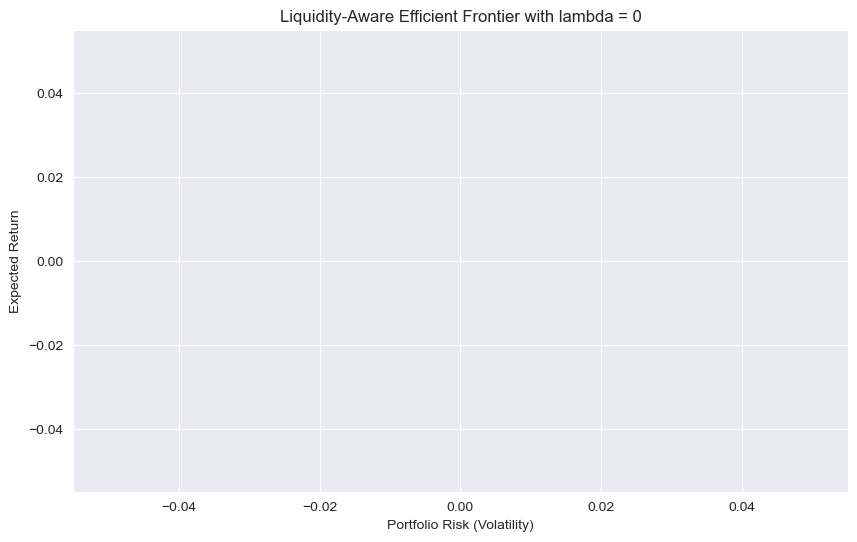

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, '-o', linewidth=2, color='black')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title("Liquidity-Aware Efficient Frontier with lambda = "+str(lambd))
plt.grid(True)
plt.show()

Enclose the above code in a function so that we can run it for different lambdas:

In [15]:
def get_efficient_frontier(mu, cov, volume_vector, lambd, n_points):
    n_assets = len(mu)
    target_returns = np.linspace(mu.min(), mu.max(), n_points)

    risks = []
    returns = []
    weights_list = []

    initial_weights = np.array([1/n_assets] * n_assets)


    for target in target_returns:
        constraints = get_constraints(mu, target)
        x0 = initial_weights  # Initial guess

        result = minimize(
            liquidity_aware_objective, x0,
            args=(cov, volume_vector, lambd),
            method='SLSQP',
            constraints=constraints,
            bounds = [(0.001, 1.0)] * n_assets
        )
        if result.success:
            optimal_weights = result.x
            portfolio_return = optimal_weights @ mu
            portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
            returns.append(portfolio_return)
            risks.append(portfolio_risk)
            weights_list.append(optimal_weights)
        else:
            print("Optimization failed at return:", target)

    return weights_list, returns, risks

Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed 

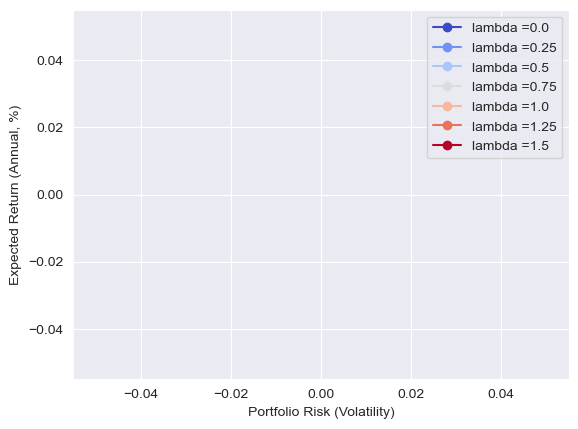

In [16]:
n_lambdas = 7
lambd_array = np.linspace(0, 1.5, n_lambdas)
# Colormap for plots
cmap = plt.cm.coolwarm 
colors = [cmap(i / (n_lambdas - 1)) for i in range(n_lambdas)]

for i in range(n_lambdas):
    opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd_array[i], n_points = 70)
    # Convert to annual returns
    returns = [100*((1 + returns[i])**252 - 1) for i in range(len(returns))]
    plt.plot(risks, returns, '-o', color=colors[i], label='lambda ='+str(round(lambd_array[i],2)))
    
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return (Annual, %)')
plt.grid(True)
plt.legend()
plt.show()

Seems like the liquidity constraint is not moving the efficient frontier at all, we can work with $\lambda = 0$.

Finally, let us generate sample portfolios on the efficient frontier with high and low risks. 

In [17]:
opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd = 0, n_points = 100)
returns = [100*((1 + returns[i])**252 - 1) for i in range(len(returns))]

Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed at return: nan
Optimization failed 

In [18]:
min_risk_index = risks.index(min(risks))
high_risk_index = len(risks)-3

ValueError: min() iterable argument is empty

In [ ]:
high_risk_portfolio = opt_weights[high_risk_index]

sorted_indices = np.argsort(-high_risk_portfolio)
high_risk_portfolio = -1*np.sort(-high_risk_portfolio)

print("A High-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    if round(high_risk_portfolio[i], 5) > 0:
        print(stock_tickers[sorted_indices[i]], round(high_risk_portfolio[i], 4))  

print('Annualized Volatility = ', round(risks[high_risk_index]*100, 2), "%")
print('Average Annual Return (Simple) = ', round(returns[high_risk_index], 2), "%")

A High-Risk Portfolio on the Efficient Frontier
MSFT 0.7578
VPU 0.2142
BOTZ 0.009
JEPQ 0.001
XLC 0.001
FBCG 0.001
MPWR 0.001
ANET 0.001
FBCV 0.001
SKYY 0.001
GOOGL 0.001
RIVN 0.001
AMZN 0.001
SOXL 0.001
VTI 0.001
VIG 0.001
VOO 0.001
VGT 0.001
SCHD 0.001
ICLN 0.001
LLY 0.001
SPY 0.001
Annualized Volatility =  45.07 %
Average Annual Return (Simple) =  49.78 %


In [ ]:
min_risk_index = 50

low_risk_portfolio = opt_weights[min_risk_index]
sorted_indices = np.argsort(-low_risk_portfolio)
low_risk_portfolio = -1*np.sort(-low_risk_portfolio)
print("A Low-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    # if round(low_risk_portfolio[i], 4) > 0:
    print(stock_tickers[sorted_indices[i]], round(low_risk_portfolio[i], 4))

print('Annualized Volatility = ', round(risks[min_risk_index]*100, 2), "%")
print('Average Annual Return (Simple) = ', round(returns[min_risk_index], 2), "%")

A Low-Risk Portfolio on the Efficient Frontier
BOTZ 0.5083
FBCG 0.1857
SPY 0.1723
VTI 0.0839
XLC 0.0182
SCHD 0.0156
SOXL 0.001
ANET 0.001
MSFT 0.001
ICLN 0.001
FBCV 0.001
MPWR 0.001
VPU 0.001
SKYY 0.001
RIVN 0.001
VGT 0.001
VIG 0.001
LLY 0.001
VOO 0.001
JEPQ 0.001
GOOGL 0.001
AMZN 0.001
Annualized Volatility =  13.43 %
Average Annual Return (Simple) =  24.26 %


Remove stocks that have less weight and recalculate returns and risks

In [ ]:
def get_clean_portfolio(data_stocks, all_tickers, weights, threshold=0.001):
    """
    Filters a portfolio based on weight threshold and computes annualized returns and volatility.
    """

    # Convert to numpy array in case input is not
    weights = np.array(weights)

    # Filter tickers and weights based on threshold
    mask = weights > threshold
    clean_stocks = [ticker for ticker, keep in zip(all_tickers, mask) if keep]
    clean_weights = weights[mask]
    
    
    # Rebalance weights to sum to 1
    clean_weights /= clean_weights.sum()
    print(weights, clean_weights)

    # Get daily returns
    # print(data.columns)
    data_sig = data_stocks[clean_stocks]
    returns = (data_sig / data_sig.shift(1)).dropna() - 1
    cov_matrix = returns.cov()
    mean_returns = returns.mean()

    # Compute portfolio return time series
    portfolio_returns = clean_weights @ mean_returns

    # Annualized return and volatility
    trading_days = 252
    annualized_return = (1+ portfolio_returns)**252 - 1
    annualized_volatility = np.sqrt(clean_weights.T @ cov_matrix @ clean_weights)

    sorted_indices = np.argsort(-clean_weights)
    clean_weights = -1*np.sort(-clean_weights)
    clean_stocks_sorted = []
    for i in range(len(clean_stocks)):
        clean_stocks_sorted.append(clean_stocks[sorted_indices[i]])

    return clean_stocks_sorted, clean_weights, annualized_return, annualized_volatility

In [ ]:
min_risk_index = 70
clean_stocks, clean_weights, annualized_return, vol = get_clean_portfolio(data, stock_tickers, opt_weights[min_risk_index], 0.005)

[0.001      0.23064884 0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.0666072
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.49995595 0.001      0.18478801] [0.23487662 0.06782811 0.50912011 0.18817516]


In [ ]:
for i in range(len(clean_stocks)):
    print(clean_stocks[i], round(10000*clean_weights[i], 2))
    
print("Annualized return: ", round(100*annualized_return, 2), "%")
# print("Volatility: ", vol)

BOTZ 5091.2
MSFT 2348.77
SPY 1881.75
VPU 678.28
Annualized return:  14.27 %


In [ ]:
yf.Ticker('ULTA').info

{'address1': '1000 Remington Boulevard',
 'address2': 'Suite 120',
 'city': 'Bolingbrook',
 'state': 'IL',
 'zip': '60440',
 'country': 'United States',
 'phone': '630 410 4800',
 'website': 'https://www.ulta.com',
 'industry': 'Specialty Retail',
 'industryKey': 'specialty-retail',
 'industryDisp': 'Specialty Retail',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Ulta Beauty, Inc. operates as a specialty beauty retailer in the United States. The company offers branded and private label beauty products, including cosmetics, fragrance, haircare, skincare, bath and body products, professional hair products, and salon styling tools through its Ulta Beauty stores, shop-in-shops, Ulta.com website, and its mobile applications. It also provides beauty services, including hair, makeup, brow, and skin services at its stores. The company was formerly known as ULTA Salon, Cosmetics & Fragrance, Inc. and changed its 